# Preprocessing


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, savgol_filter, find_peaks
from scipy.spatial import distance
import tkinter
from tkinter import filedialog
from tqdm import tqdm
from scipy.ndimage import median_filter

## Helper Functions
### Initial Preprocessing

Extract direction of walk:

In [2]:
def extract_walk_direction(filename):
    # extract direction of the walk 
    if "back" in filename:
        direction = "back"
    elif "front" in filename:
        direction = "front"
    else:
        raise ValueError("File path must contain either 'back' or 'front' to determine the direction of the walk")
    
    return direction

Remove unneeded features:

In [3]:
def filter_columns(df):
	keypoints = ["RAnkle", "LAnkle", "RKnee", "LKnee", "RHip", "LHip", "LShoulder", "RShoulder", "RElbow", "LElbow", "RWrist", "LWrist"]

	columns = [f"{kp}_x" for kp in keypoints] + [f"{kp}_y" for kp in keypoints]

	return df.loc[:, df.columns.isin(columns)]

Smooth using a moving average, median filter, or using a Savitzky-Golay filter 


In [4]:
def smoothing(data, filter):
    window = 5

    if filter == "average": 
        smooth = data.rolling(window=window).mean()
        smooth = smooth.fillna(data).tolist()
    elif filter == "savgol":
        order = 2
        smooth = savgol_filter(data, window, order, deriv=1, delta=data.time[1]-data.time[0])
    elif filter == "median":
        smooth = median_filter(data, size=window)
        smooth = list(smooth)

    return smooth

Butterworth filter


In [5]:
def butterworth_filter(data, fs):
    """
    Use Butterworth filtering to reduce high-frequency noise
    """

    cutoff = 8  # Cutoff frequency in Hz
    order = 2  
    btype = "lowpass" 

    b, a = butter(order, cutoff / (0.5 * fs), btype=btype)
    buttered = filtfilt(b, a, data)

    return buttered

Initial Preprocessing - full function

In [6]:
def initial_preprocessing(df, filter="average"):
    # remove unused columns
    new_df = filter_columns(df)
    
    # smooth the coordinates
    new_df = new_df.apply(lambda column: smoothing(column, filter=filter))

    # use butterworth filter
    fs = 1 / df['time'].diff().mean()
    new_df = new_df.apply(lambda column: butterworth_filter(column, fs))

    return pd.concat([df["time"], new_df], axis=1)

### Gait Parameter Preprocessing

Detect the moments of heel strike and toe off for a single leg:

In [7]:
def detect_steps(data, direction=''):
    """
    data: time series of the y-pixel of the ankle
    direction: front or back

    returns:
        heel_strikes: the indexes of when the heel first touches the ground 
    """

    dist = 20 # minimum distance between two detected steps taken on a single leg

    if not direction:
        direction = input("Choose walk direction: 'front' or 'back'?")

    # find peaks in the derivative of the y-coord of the ankle
    deriv  = np.gradient(data)
    if direction == 'front':
        peaks, _ = find_peaks(deriv, distance=dist)
    elif direction == 'back':
        peaks, _ = find_peaks(-deriv, distance=dist)

    # detect heel-strikes and toe-offs
    heel_strikes = []
    toe_offs = []
    for peak in peaks:
        peak_height = deriv[peak]
        heel_threshold = 0.35 * abs(peak_height) # heel strike occurs after each peak of the derivative, once the 35% of peak height is crossed
        toe_threshold = 0.3 * abs(peak_height) # toe-off occurs before each peak of the derivative, once the 30% of peak height is crossed

        # heel strikes
        for i in range(peak + 1, len(deriv)):
            if abs(deriv[i]) <= heel_threshold:
                heel_strikes.append(i)
                break
            
        # toe-offs
        for i in range(peak - 1, -1, -1):
            if abs(deriv[i]) <= toe_threshold:
                toe_offs.append(i)
                break

    return heel_strikes, toe_offs

#### For step time
Generating binary time series - 0 for when foot is in the air, 1 for when foot is on the floor: 

In [8]:
def foot_on_floor(Heels, Toes, total_frames):
    """
    Create a series of 0s and 1s indicating if the foot is (1) or isn't (0) on the floor. This intends to create a time series representation of cadence.
    
    Heels (list): List of indexes where the heel-strike occurs.
    Toes (list): List of indexes where the toe-off occurs.
    total_frames (int): Total number of frames in the video.

    """

    foot_on_floor = [0] * total_frames

    # handle case where video starts mid-step (no initial heel strike)
    if Toes[0] < Heels[0]:
        for i in range(0, Toes[0] + 1):  # foot on floor from first frame until first toe-off
            foot_on_floor[i] = 1

    # handle case where video ends mid-step (no final toe-off)
    if Heels[-1] > Toes[-1]:
        for i in range(Heels[-1], total_frames):  # foot stays on floor until last frame
            foot_on_floor[i] = 1
    
    # handle all other regular cases
    i, j = 0, 0  # pointers for Heels and Toes

    while i < len(Heels) and j < len(Toes):
        if Heels[i] < Toes[j]:
            # mark the foot as on the floor from heel-strike to toe-off
            for frame in range(Heels[i], Toes[j] + 1):
                foot_on_floor[frame] = 1
            i += 1
            j += 1
        else:
            # If a toe-off comes before the next heel-strike
            j += 1
    
    return foot_on_floor


#### Finding the step width
This is calculated by finding the euclidean distance between the ankle joints for each frame, then dividing it by the euclidean distance of the two hip keypoints to normalise it

In [17]:
def get_step_width_distances(row):
    """
    Return the distances between left and right ankle, and left and right hips per frame
    """

    ankles = distance.euclidean(row[["RAnkle_x", "RAnkle_y"]], row[["LAnkle_x", "LAnkle_y"]])
    hips = distance.euclidean(row[["LHip_x", "LHip_y"]], row[["RHip_x", "RHip_y"]])

    return ankles, hips

def get_step_width(df):
    """
    Returns the distance between the two ankles, normalised by the width of the hip
    """
    
    distances = df.apply(lambda row: pd.Series(get_step_width_distances(row)), axis=1)
    distances.columns = ['ankle_distance', 'hip_distance']

    return distances['ankle_distance'] / smoothing(distances['hip_distance'], filter="average")


#### Finding margin of stability (MOS)

The following systematic review gives a good overview of how this is calculated: https://doi.org/10.1186%2Fs12891-021-04466-4


It is a lengthy process which can be summarised with the equation

$\text{MOS} = \text{BOS} - \text{XCOM}$

Where BOS is the base of support (the foot) and XCOM is the extrapolated centre of mass

In [10]:
def find_MOS(df, RHeels, LHeels, direction):
    # estimated center of mass (eCOM) - the middle point between the two hip keypoints
    if direction == "back":
        df["eCOM_x"] = ((df['RHip_x'] - df['LHip_x']) / 2) + df["LHip_x"]
    elif direction == "front":
        df["eCOM_x"] = ((df['LHip_x'] - df['RHip_x']) / 2) + df["RHip_x"]

    # Find the hip width in each frame in order to normalise the leg lengths 
    df["Hip_width"] = abs(df['LHip_x'] - df['RHip_x'])

    # Find leg length in each frame where a heel strike occurs
    # Right leg
    df_RHeels = df.loc[RHeels]
    df_RHeels["LegLen"] = df_RHeels.apply(lambda row: np.sqrt((row['RHip_y'] - row['RAnkle_y'])**2 + (row['RHip_x'] - row['RAnkle_x'])**2) / row['Hip_width'], axis=1)

    # Left leg
    df_LHeels = df.loc[LHeels]
    df_LHeels["LegLen"] = df_LHeels.apply(lambda row: np.sqrt((row['LHip_y'] - row['LAnkle_y'])**2 + (row['LHip_x'] - row['LAnkle_x'])**2) / row['Hip_width'], axis=1)

    # Average leg length 
    meanLegLen = np.mean(df_RHeels.LegLen.tolist() + df_LHeels.LegLen.tolist())

    # Finding the extrapolated center of mass (XCOM)
    omega = np.sqrt(9.81/meanLegLen); # the natural frequency of the pendulum-like leg
    vCOM = np.gradient(df.eCOM_x)

    XCOM = df.eCOM_x + (vCOM/omega)


    # Calculating the estimated margin of stability (eMOS) in the mediolateral direction

    # first, finding the x-axis pixel difference from the XCOM to the right and left ankle, normalised by the hip width
    if direction == "front":
        RMOS0 =  (-XCOM + df.RAnkle_x)/df.Hip_width; 
        LMOS0 =  (-XCOM + df.LAnkle_x)/df.Hip_width;
    elif direction == "back":
        RMOS0 =  (XCOM - df.RAnkle_x)/df.Hip_width; 
        LMOS0 =  (XCOM - df.LAnkle_x)/df.Hip_width;

    # as explained in the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8240253/#CR7, the code above is the calcualtion equivalent to the formula
    # MOS = -XCOM + BOS
    # Where the BOS is the base of support. When walking, the base of support switches from the left to the right and vice versa on each step.
    # Hence, the RMOS may only exist from the moment the right heel strikes, until the following left heel strike, and vice versa:

    df["MOS"] = np.nan

    # NOTE: all left leg MOS values have been multiplied by -1 in order for the MOS to signify the same type of instability, regardless of what leg is being stood on. 
    # This is set up such that a large +ve value indicates instability in the lateral direction, and a large -ve value indicates instability in the medial direction.

    if min(RHeels) < min(LHeels):
        for j in range(0, min(RHeels)):
            df.loc[j, 'MOS'] = LMOS0[j] * -1
    else:
        for j in range(0, min(LHeels)):
            df.loc[j, 'MOS'] = RMOS0[j]


    # Loop through each full right step for RMOS
    for i, HeelLoc in enumerate(RHeels):
        # find at which video frame the next left heel strike is occuring, unless the video ends before the next strike
        try:
            endLoc = LHeels[i] if LHeels[i] > HeelLoc else LHeels[i+1]
        except IndexError:
            endLoc = df.index[-1]

        # add the values between the heel strike and the following opposing leg heel strike to the MOS
        for j in range(HeelLoc, endLoc + 1):
            df.loc[j, 'MOS'] = RMOS0[j]


    # Loop through each full right step for RMOS
    for i, HeelLoc in enumerate(LHeels):
        # find at which video frame the next right heel strike is occuring, unless the video ends before the next strike
        try:
            endLoc = RHeels[i] if RHeels[i] > HeelLoc else RHeels[i+1]
        except IndexError:
            endLoc = df.index[-1]
        
        # add the values between the heel strike and the following opposing leg heel strike to the MOS
        for j in range(HeelLoc, endLoc + 1):
            df.loc[j, 'MOS'] = LMOS0[j] * -1
            
    
    if df["MOS"].isna().any():
        raise ValueError(f"MOS contains NaNs.")

    df.drop(columns=['eCOM_x', 'Hip_width'], axis=1, inplace=True)

    return df.MOS


### Gait parameter extraction - full process

In [11]:
def gait_variable_preprocessing(df, direction):
    # find heel strikes and toe offs of each leg
    RHeels, RToes = detect_steps(df.RAnkle_y, direction=direction)
    LHeels, LToes = detect_steps(df.LAnkle_y, direction=direction)

    # generate binary time series to descripe when each foot is placed on the floor
    df["RAnkle_onfloor"] = foot_on_floor(RHeels, RToes, len(df))
    df["LAnkle_onfloor"] = foot_on_floor(LHeels, LToes, len(df))

    # calculate step width per frame
    df["step_width"] = get_step_width(df)

    # calculate the margin of stability (MOS)
    df["MOS"] = find_MOS(df, RHeels, LHeels, direction=direction)

    return df

## Normalisation

In [12]:
def normalise_keypoints(df):
    keypoints = ["RAnkle", "LAnkle", "RKnee", "LKnee", "RHip", "LHip", "LShoulder", "RShoulder", "RElbow", "LElbow", "RWrist", "LWrist"]

    # find the width of the hip and smooth it
    hip_width = df.apply(lambda row: distance.euclidean(row[["LHip_x", "LHip_y"]], row[["RHip_x", "RHip_y"]]), axis=1)
    hip_width = smoothing(hip_width, "average")

    for keypoint in keypoints:
        # df[f"{keypoint}_x"] = df[f"{keypoint}_x"] / hip_width
        # df[f"{keypoint}_y"] = df[f"{keypoint}_y"] / hip_width

        # look for the max and min value of the x and y axes in order to normalise to that scale
        min_x = df[f"{keypoint}_x"].min()
        min_y = df[f"{keypoint}_y"].min()
        max_x = df[f"{keypoint}_x"].max()
        max_y = df[f"{keypoint}_y"].max()

        # calibrate such that each coordinate is normalised to the range of 0 to 1
        df[f"{keypoint}_x"] = (df[f"{keypoint}_x"] - min_x) / (max_x - min_x)
        df[f"{keypoint}_y"] = (df[f"{keypoint}_y"] - min_y) / (max_y - min_y)

    return df
    

## Full file preprocessing

In [13]:
def preprocess_file(file_path, output_dir):
    # read file
    df = pd.read_csv(file_path)

    # extract direction of the walk - front or back
    file_name = os.path.basename(file_path)
    direction = extract_walk_direction(file_name)

    # smoothing, filtering, feature selection
    df = initial_preprocessing(df)

    # extract step width, cadence and MOS
    df = gait_variable_preprocessing(df, direction)

    # normalise the leg keypoints by hip width
    df = normalise_keypoints(df)

    # save new datafram to csv
    df.to_csv(os.path.join(output_dir, file_name), index=False)

    return df

In [23]:
tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing
# output_path = filedialog.askdirectory(title="output directory")
file_path = filedialog.askopenfilename(title="input")


In [24]:
test_df = preprocess_file(file_path, output_path)

## Plots

Text(0.5, 1.0, 'Left Ankle')

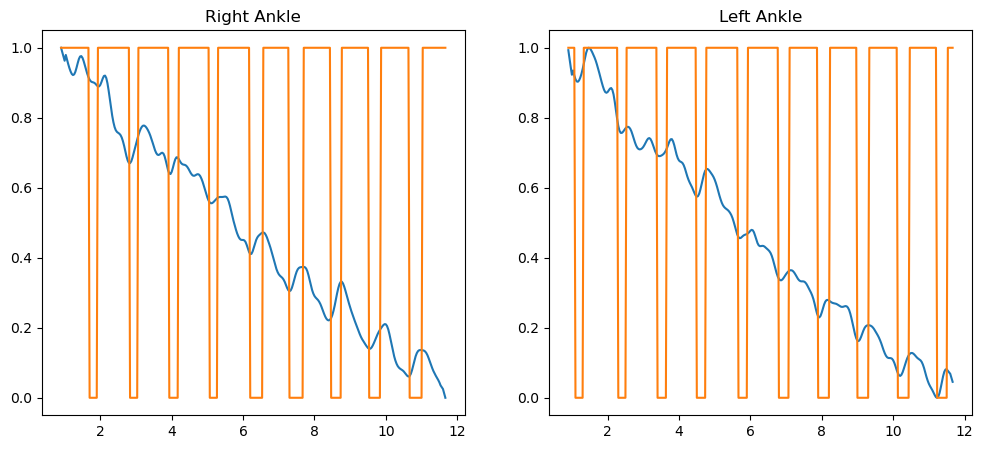

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(test_df.time, test_df.RAnkle_y)
plt.plot(test_df.time, test_df.RAnkle_onfloor)
plt.title('Right Ankle')
plt.subplot(1,2,2)
plt.plot(test_df.time, test_df.LAnkle_y)
plt.plot(test_df.time, test_df.LAnkle_onfloor)
plt.title('Left Ankle')

Text(0.5, 1.0, 'Left Ankle')

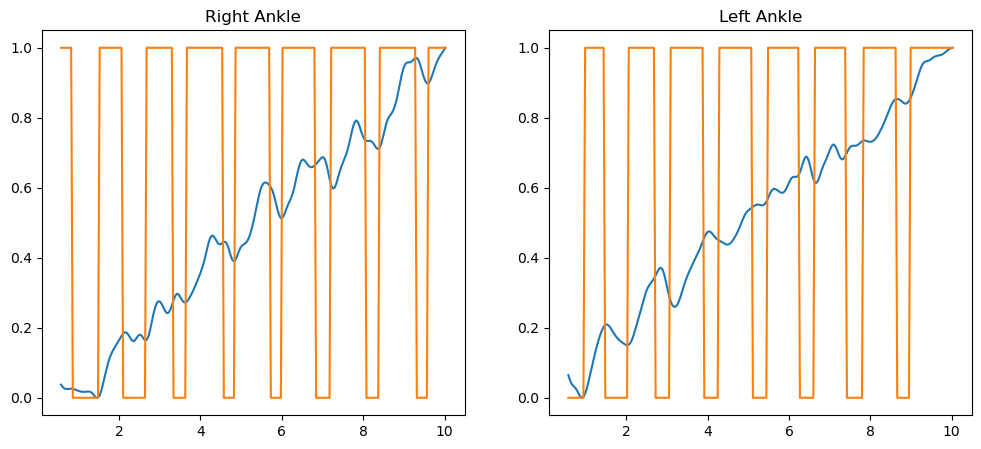

In [72]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(test_df.time, test_df.RAnkle_y)
plt.plot(test_df.time, test_df.RAnkle_onfloor)
plt.title('Right Ankle')
plt.subplot(1,2,2)
plt.plot(test_df.time, test_df.LAnkle_y)
plt.plot(test_df.time, test_df.LAnkle_onfloor)
plt.title('Left Ankle')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-0.5, 2.0)

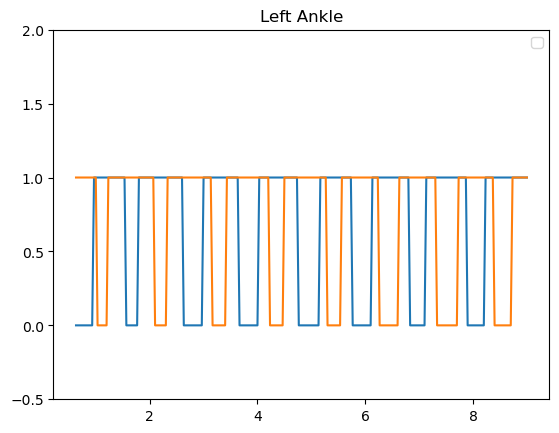

In [25]:
ax = plt.figure()
plt.plot(test_df.time, test_df.RAnkle_onfloor)
plt.title('Right Ankle')
plt.plot(test_df.time, test_df.LAnkle_onfloor)
plt.title('Left Ankle')
plt.legend()
plt.ylim([-0.5, 2])

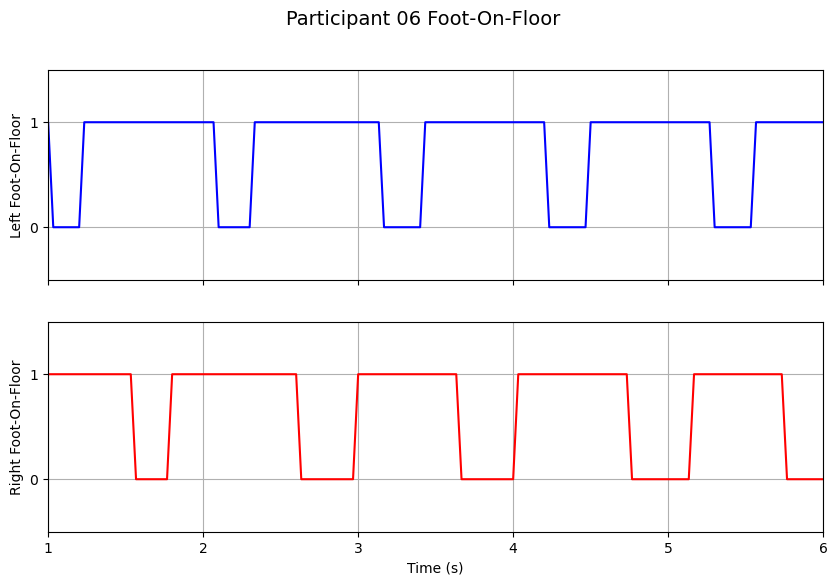

In [41]:
# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
plt.suptitle("Participant 06 Foot-On-Floor", fontsize=14)

# Plot left foot-on-floor
ax1.plot(test_df.time, test_df.LAnkle_onfloor, color='blue')
ax1.set_ylim(-0.5, 1.5)
ax1.set_yticks([0, 1])
ax1.set_xlim(1, 6)
ax1.set_ylabel('Left Foot-On-Floor')
ax1.grid(True)

# Plot right foot-on-floor
ax2.plot(test_df.time, test_df.RAnkle_onfloor, color='red')
ax2.set_ylim(-0.5, 1.5)
ax2.set_yticks([0, 1])
ax2.set_xlim(1, 6)
ax2.set_ylabel('Right Foot-On-Floor')
ax2.grid(True)

# Common x label
plt.xlabel('Time (s)')


# Show the plot
plt.show()


## Batch Preprocessing

Run this section to preprocess an entire directory of CSV files at a time.

Load input file directory:

In [57]:
tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing
dir_path = filedialog.askdirectory(title="Select input directory")
output_path = filedialog.askdirectory(title="Select output directory")

In [84]:
dir_path = filedialog.askdirectory(title="Select input directory") # input
print(dir_path)
# all CSV files in the parent directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]


C:/Users/galga/OneDrive - University of Reading/MSc/MSc Project/Pose-Tracking/Detectron/14


In [85]:
for file in tqdm(csv_files, desc="Preprocessing CSV files"):
    preprocess_file(os.path.join(dir_path, file), output_path)

Preprocessing CSV files: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]
